In [1]:
import os
os.chdir("..")

In [2]:
from mlengine.config.settings import settings
from mlengine.common.logger import logger

2023-12-14 23:21:32 DESKTOP-PEC6JQ0 12_14_2023_23_21_32.log[12048] INFO Logging initialized.
******************************
2023-12-14 23:21:32 DESKTOP-PEC6JQ0 12_14_2023_23_21_32.log[12048] INFO Settings file [d:\PycharmProjects\ml-app\src\mlengine\config\settings.yaml] loaded successfully.
******************************


In [3]:
import pandas as pd
import pydantic

In [4]:
data_validation_settings = settings.data_validation

In [5]:
df = pd.read_csv(data_validation_settings.req_files[0], delimiter=',')

In [6]:
class DataValidator(pydantic.BaseModel):
    gender: pydantic.StrictStr
    race_ethnicity: pydantic.StrictStr
    parental_level_of_education: pydantic.StrictStr
    lunch: pydantic.StrictStr
    test_preparation_course: pydantic.StrictStr
    math_score: pydantic.StrictInt
    reading_score: pydantic.StrictInt
    writing_score: pydantic.StrictInt

In [7]:
data_list = [DataValidator(**row) for _, row in df.iterrows()]

In [8]:
df.isna().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [11]:
print(df.nunique())

gender                          2
race_ethnicity                  5
parental_level_of_education     6
lunch                           2
test_preparation_course         2
math_score                     81
reading_score                  72
writing_score                  77
dtype: int64


In [12]:
df.describe()

,math_score,reading_score,writing_score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [13]:
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']
df['average'] = df['total_score']/3
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


In [14]:
df['average'].skew()

-0.29905711750168584

In [15]:
df['average'].kurt()

0.12584287362370628

In [16]:
df = df.drop(['total_score', 'average'], axis=1)

In [17]:
df

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [18]:
# from mlengine.plots.dist import histograms_across_feats, distplots_across_feats, plot_features

In [19]:
from mlengine.dataops.dataframe import is_numeric, group_below_top_n, get_num_cols, get_cat_cols

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
plt.style.use('ggplot')

In [21]:
def histograms_across_feats(df: pd.DataFrame, column: str):
    """
    Function that plots histograms of a given column data (with kde for numerical data) across other CATEGORICAL features and their respective groups

    :param df: Pandas DataFrame - data to be plotted on histograms or pie charts
    :param column: str, name of the DataFrame column to be plotted
    :return: None
    """

    def rotate_xticklabels(axs):
        axs.set_xticks(axs.get_xticks())
        axs.set_xticklabels(axs.get_xticklabels(), rotation=40, ha="right")

    kde = bool(is_numeric(df[column]))
    cat_feats = get_cat_cols(df)

    fig, axs = plt.subplots(1, len(cat_feats) + 1, figsize=(25, 5))

    sns.histplot(data=df, x=column, bins=30, kde=kde, ax=axs[0], color='g')
    rotate_xticklabels(axs[0])

    for i, col in enumerate(cat_feats):
        sns.histplot(data=df, x=column, bins=30, kde=kde, ax=axs[i + 1], hue=col)
        rotate_xticklabels(axs[i + 1])

    plt.show()

In [22]:
# plot_features(df)

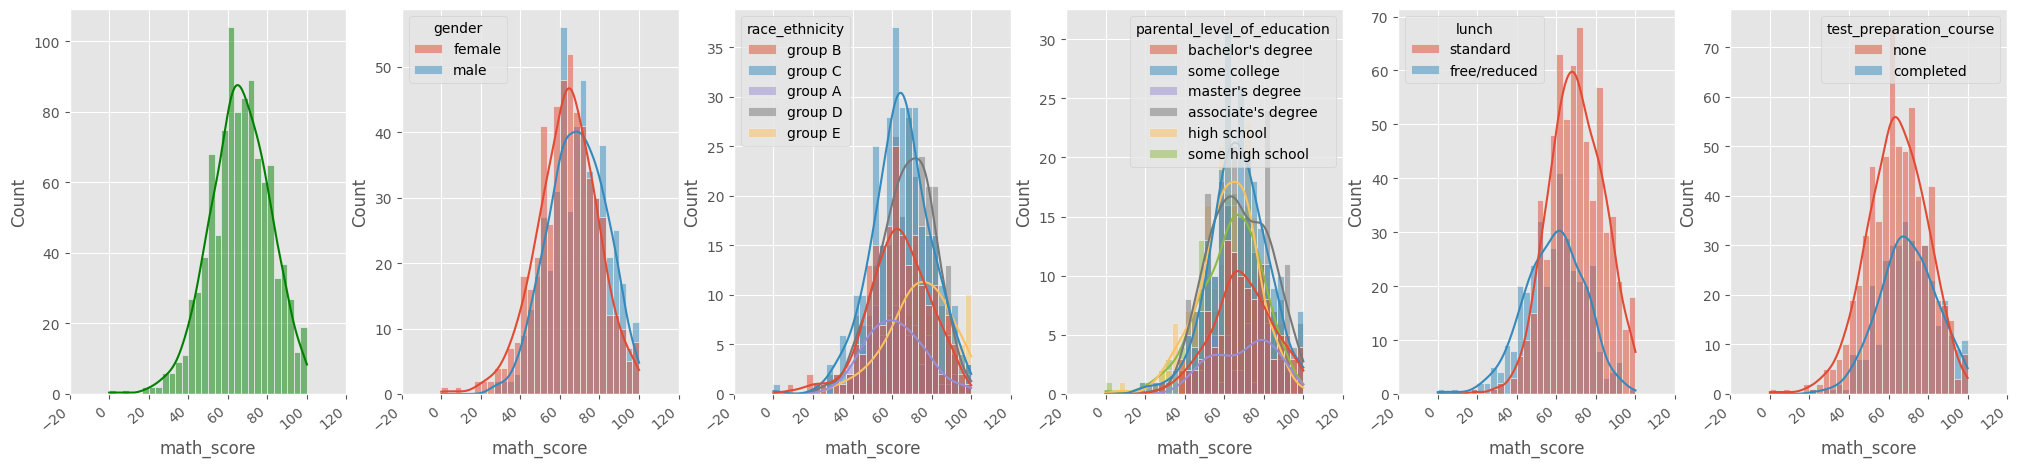

In [23]:
histograms_across_feats(df, column='math_score')

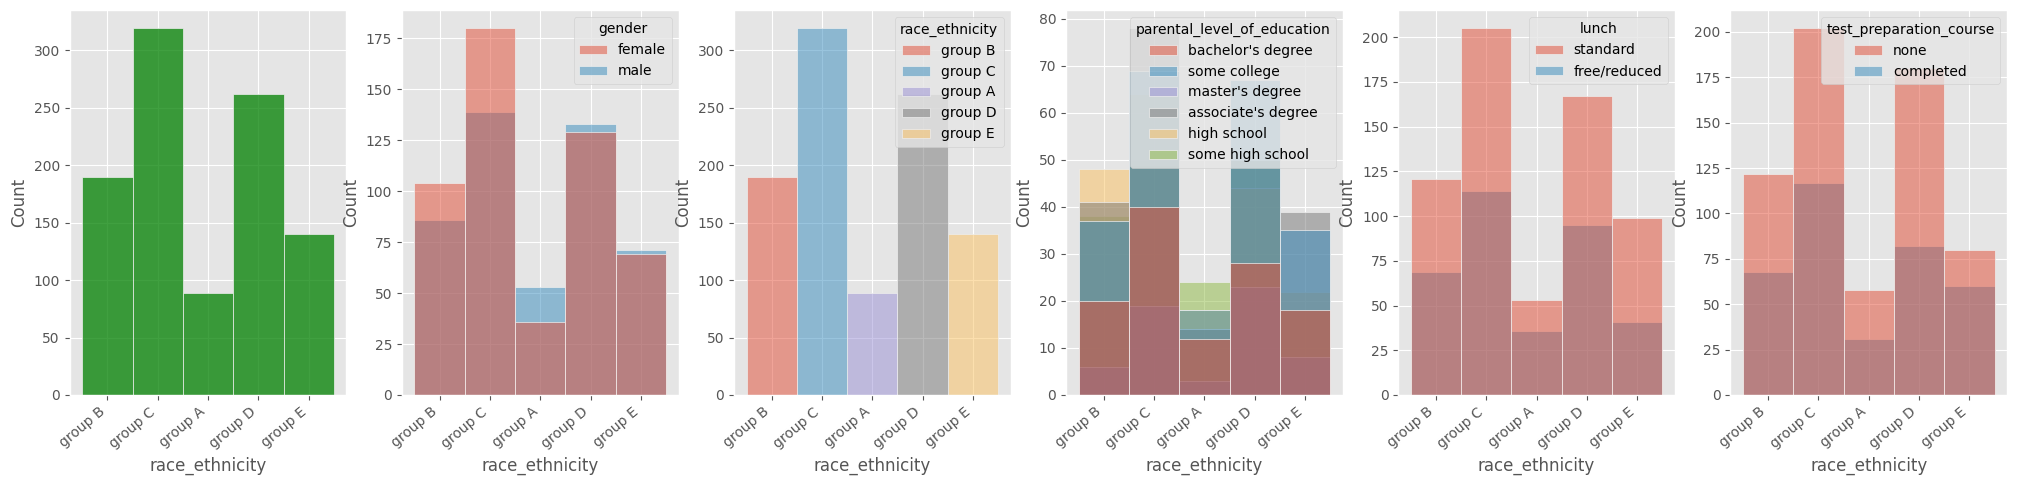

In [24]:
histograms_across_feats(df, column='race_ethnicity')

In [25]:
def rotate_xticklabels(axs, rotation=40, ha='right'):
      axs.set_xticks(axs.get_xticks())
      axs.set_xticklabels(axs.get_xticklabels(), rotation=rotation, ha=ha)

def setup_plots_grid(num_plots, max_cols_in_row=6):
    num_rows = num_plots // max_cols_in_row + 1 * (num_plots % max_cols_in_row > 0)  # 7 // 6 + 1*(1) = 1 + 1 = 2, 7 // 7 + 1*(0) = 1, 7 // 8 + 1*(1) = 0 + 1 = 1

    if num_rows == 1:
        num_cols = num_plots
    else:
        num_cols = max_cols_in_row
    
    return num_rows, num_cols

def setup_plots_grid_size(num_rows, num_cols):
    figsize = (num_cols * 7, num_rows * 8)
    return figsize

In [26]:
color_dark_cyan = '#065054'  # #075f63

In [138]:
def distribution_plots(df, option='violin', by_col=None, hue=None, target=None):
   num_rows, num_cols = setup_plots_grid(num_plots=len(df.columns), max_cols_in_row=8)  # num_plots=len(df.columns) - 1
   figsize = setup_plots_grid_size(num_rows, num_cols)
   fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

   for i, col in enumerate(df.columns):  # df.columns.drop(target)
      row_num = i // num_cols
      col_num = i % num_cols

      if num_rows == 1:
         ax = axs[col_num]
      else:
         ax = axs[row_num, col_num]
      
      pallete = 'tab10' if hue is not None else None

      # x, y = (col, target) if target is not None else (col, None)

      match option:
            case 'violin':
               # sns.violinplot(data=df, x=target, y=col, bw_adjust=.5, hue=hue, palette=pallete, ax=ax).set(title=f'{col} by {target}.')  # or target by col for numerical
               sns.violinplot(data=df, x=col, bw_adjust=.5, hue=hue, palette=pallete, ax=ax).set(title=f'{col}.')  # or target by col for numerical
            case 'kde-hist-feats':
               sns.histplot(data=df, x=col, color=color_dark_cyan, hue=hue, palette=pallete, kde=True, ax=ax).set(title=f'Histogram of {col}')
            case 'kde-hist-target':
               if col in get_cat_cols(df):
                  sns.histplot(data=df, x=target, color=color_dark_cyan, hue=col, palette=pallete, kde=True, ax=ax).set(title=f'Histogram of {col}')  # todo: only for continuous col
               else:
                  sns.scatterplot(data=df, x=target, y=col, hue=hue, palette=pallete, ax=ax)
            case 'heatmap':
               sns.histplot(data=df, x=col, y=by_col, color=color_dark_cyan, hue=hue, palette=pallete, ax=ax).set(title=f'Heatmap of {col} vs {by_col}')
            case 'boxplot':
               # sns.boxplot(data=df, x=x, color=color_dark_cyan, hue=hue, palette=pallete, ax=ax).set(title=f'Boxplot of {col}')
               sns.boxplot(data=df, x=col, y=by_col, color=color_dark_cyan, hue=hue, palette=pallete, ax=ax).set(title=f'Boxplot of {col}')

      rotate_xticklabels(ax)

   plt.show()

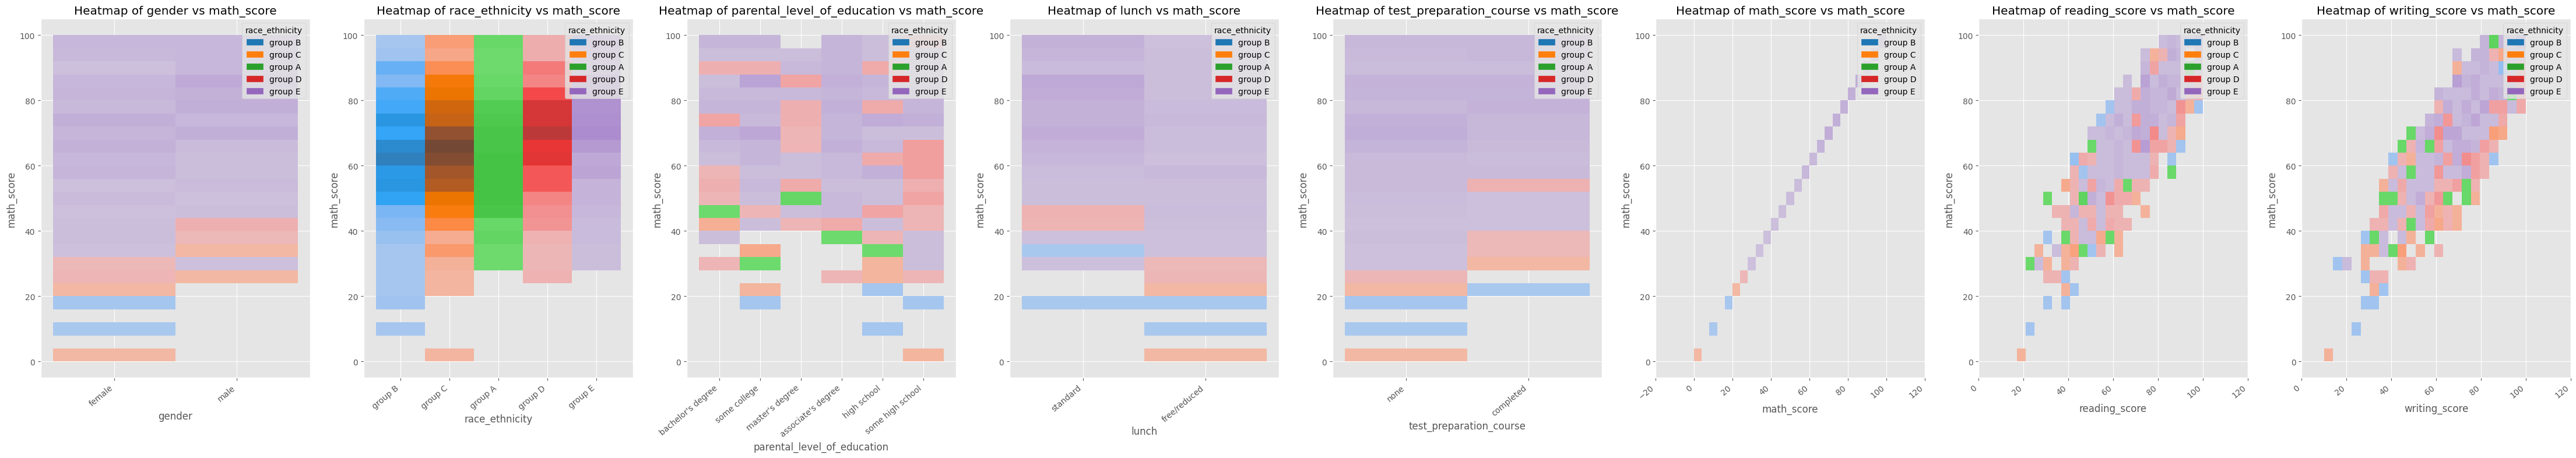

In [110]:
distribution_plots(df=df, option='heatmap', by_col='math_score', hue='race_ethnicity')

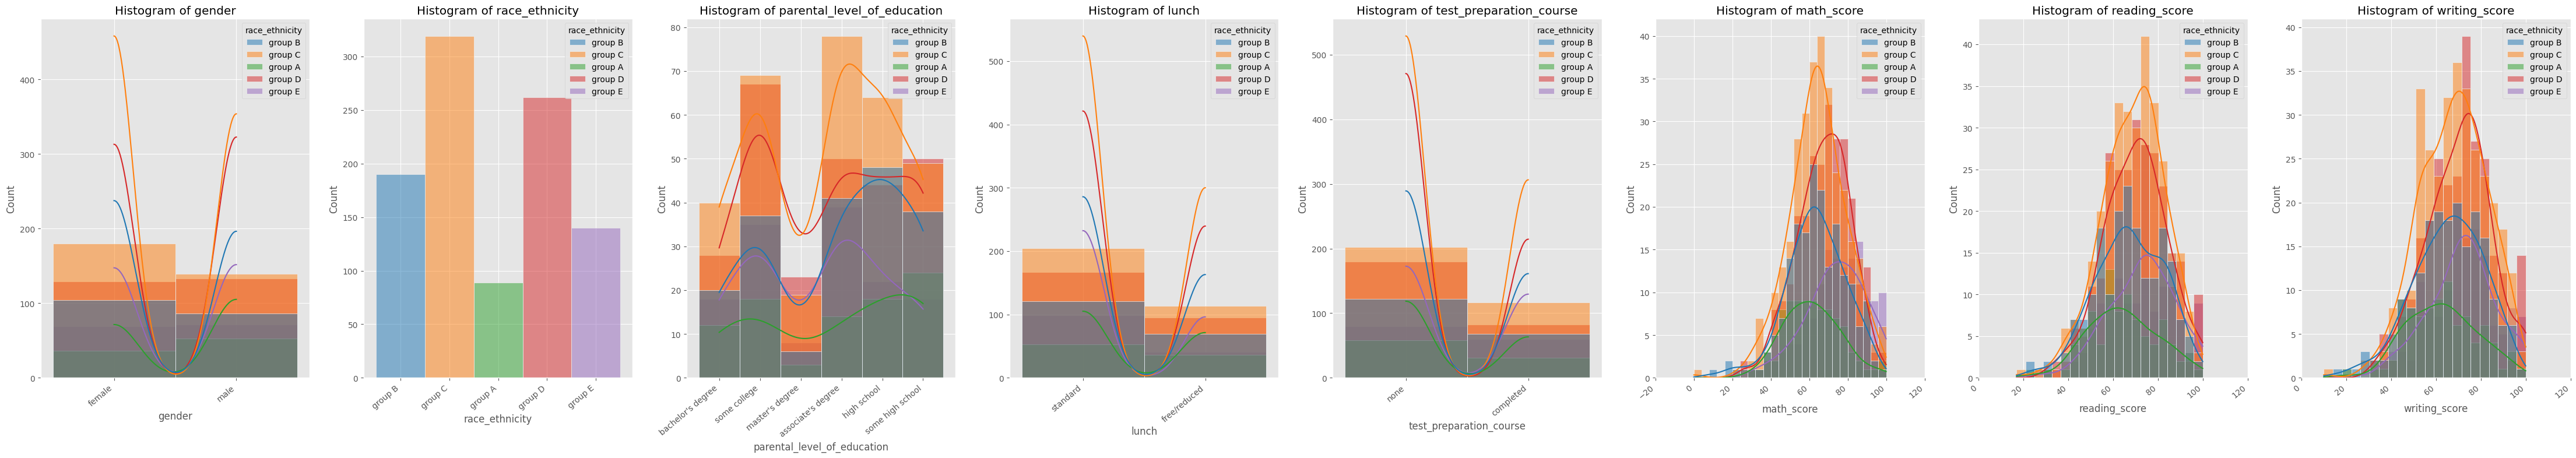

In [126]:
distribution_plots(df=df, option='kde-hist-feats', hue='race_ethnicity')  # distribution_plots(df=df, option='kde-hist', hue='math_score') is invalid for continuous hue

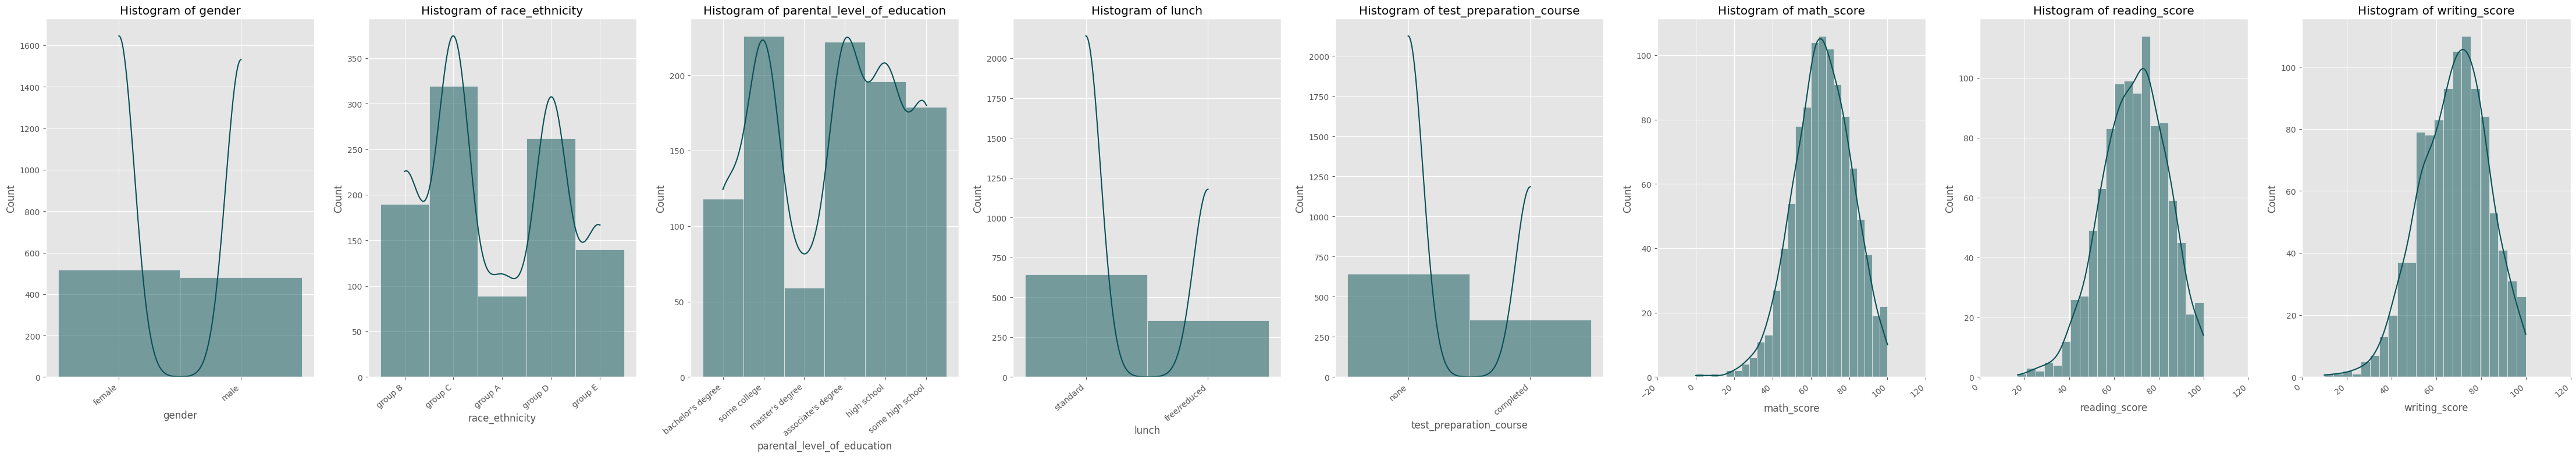

In [127]:
distribution_plots(df=df, option='kde-hist-feats')  # target can be None, then to plot variables across other variable use hue, but can also plot df variables by target (and can also do hue)

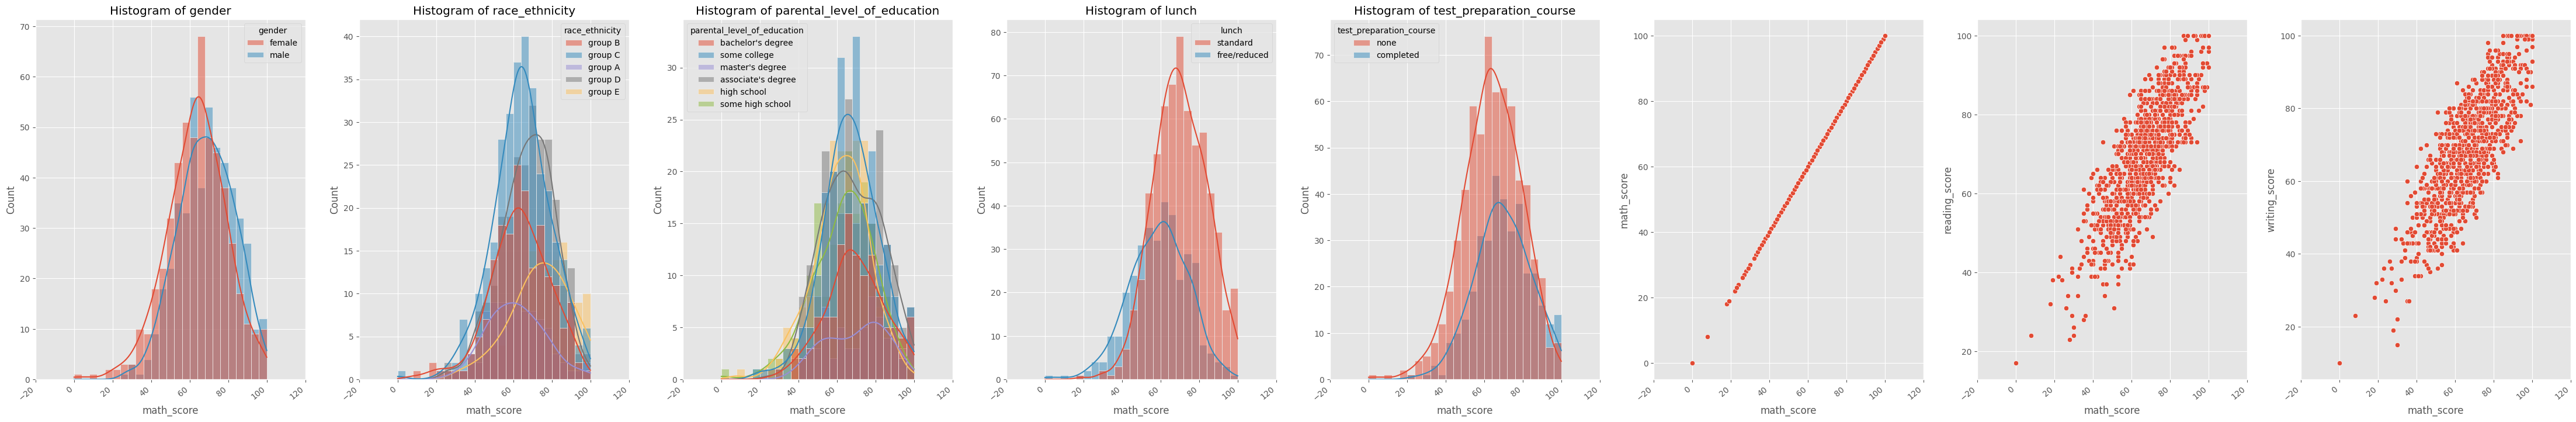

In [139]:
distribution_plots(df=df, option='kde-hist-target', target='math_score')

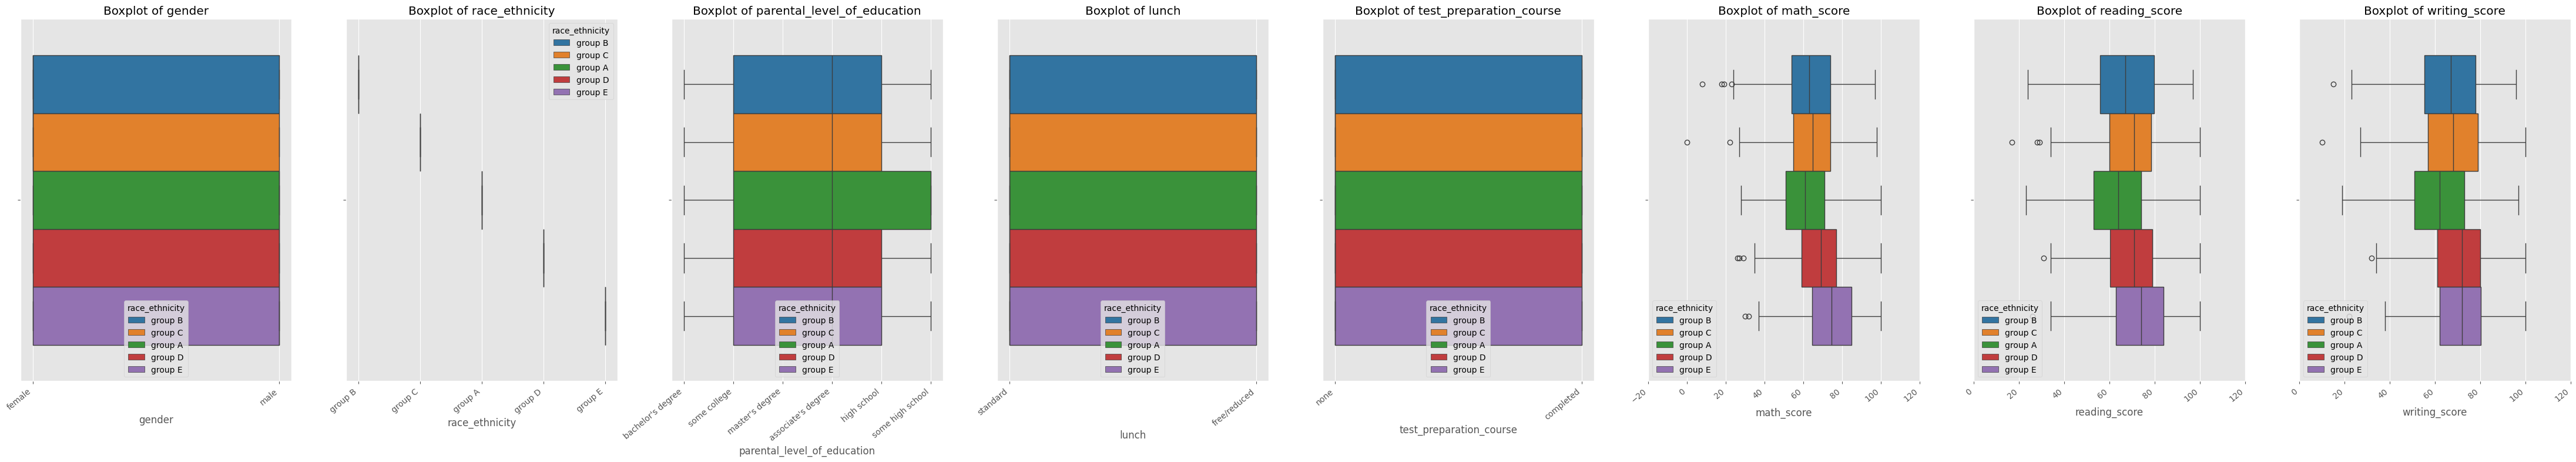

In [30]:
distribution_plots(df=df, hue='race_ethnicity', option='boxplot')  # distribution_plots(df=df, target='race_ethnicity', option='boxplot', hue='math_score') is nono

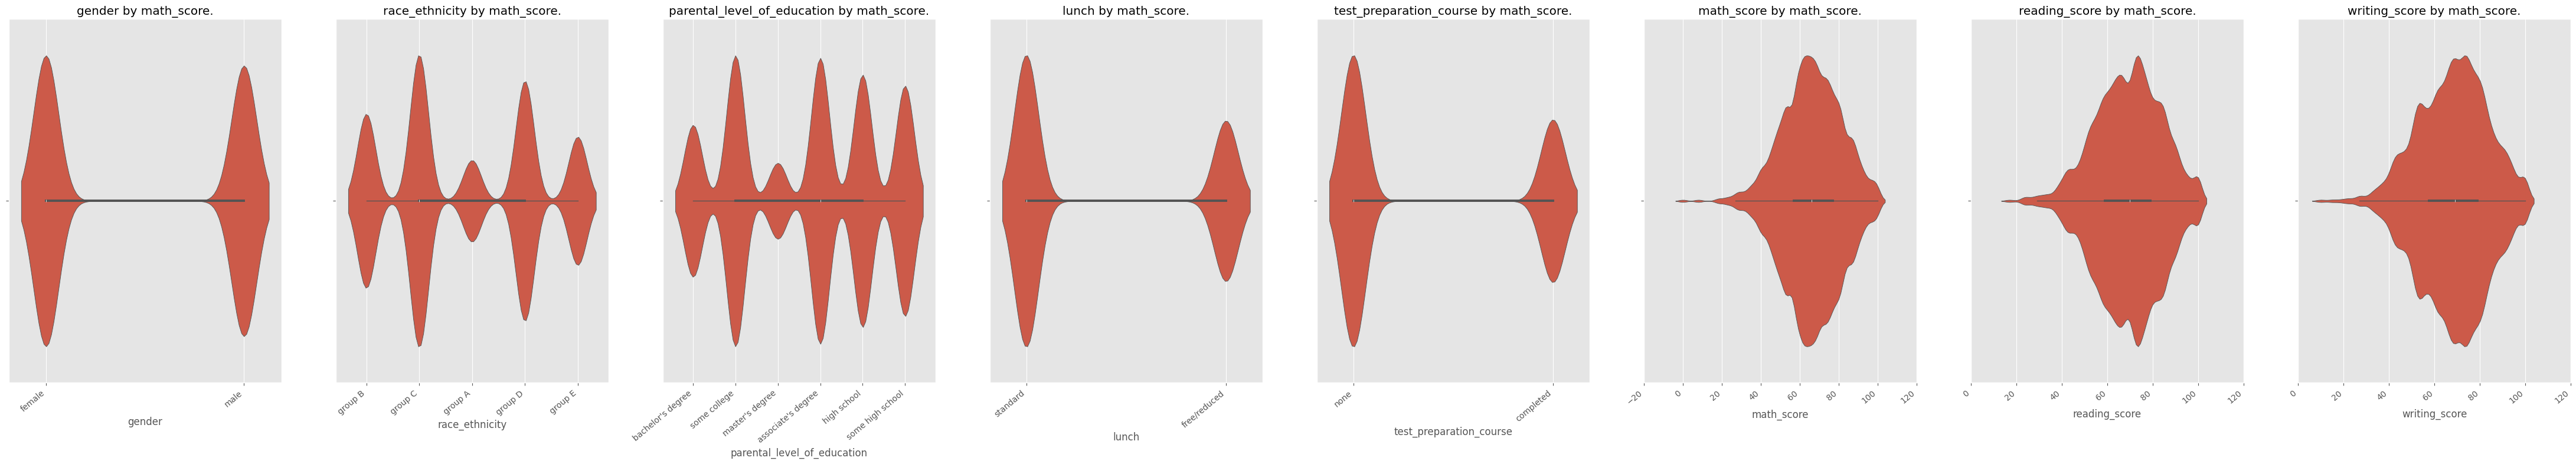

In [31]:
distribution_plots(df=df, target='math_score', option='violin') #, hue='gender'
# if target is discrete then both discrete and continuous features are fine
# if target is continuous then discrete features are fine, continuous features seem to plot a lot of small plots, investigate?

In [32]:
df

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [33]:
sns.pairplot(df, vars=rdf.columns)

NameError: name 'rdf' is not defined

In [ ]:
distplots_across_feats(df, column='average', mode='box') # box, violin, rug